In [1]:
%cd ..

/home/burak/repos/smartrag


/home/burak/repos/smartrag/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
from disambiguation_methods.qa import chain_answer
from disambiguation_methods.score import chain_score
from disambiguation_methods.score_2 import chain_score as chain_score2

from collections import defaultdict
from disambiguation_methods.qa import AnswerStr
from disambiguation_methods.score import AnswerJudge
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableConfig
from models import QueryAmbiguation
import pandas as pd
import json
from disambiguation_methods.domain_extractor import categories

from tqdm import tqdm

In [6]:
top_n = 10
dataset_name = "medquad_unfiltered"
domain = None
# experiment = f"top{top_n}+DOMAIN+LLM+Intent+MLM+TE+LLM"
experiment = "DOMAIN+Intent"

In [7]:
df = pd.read_csv(f"./data/{dataset_name}_{experiment}.csv")

In [8]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["amb"]))
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["unamb"]))
lm3 = RunnableLambda(lambda x: chain_answer.invoke(x["disamb"]))
chain_ = RunnableParallel(amb=lm1, unamb=lm2, disamb=lm3)

In [ ]:
methods = [
    "MLM",
    "MLM_NO_INTENT",
    "MLM_NO_DOMAIN",
    "TE",
    "TE_NO_INTENT",
    "TE_NO_DOMAIN",
    "LLM",
    "LLM_NO_INTENT",
    "LLM_NO_DOMAIN",
    "LLM2",
]

### Ambiguity Experiments

In [41]:
for method in methods:
    for df_index in tqdm(range(len(df))):
        ambiguities = QueryAmbiguation(**json.loads(df.loc[df_index, "possible_ambiguities"]))
        if "LLM2" not in method:
            most_likely_full_forms: list[str] = json.loads(
                df.loc[df_index, f"{method.split("_")[0]}_most_likely_full_forms"]
            )
        else:
            most_likely_full_forms: list[str] = json.loads(df.loc[df_index, f"llm_full_form_suggestions"])

        disambiguated_question_answers = []
        unambiguous_question_answers = []
        ambiguous_question_answers = []

        evaluation = {"amb": [], "disamb": [], "unamb": []}

        for full_form, amb in zip(most_likely_full_forms, ambiguities.full_form_abbrv_map):
            amb_question: str = df.loc[df_index, "ambiguous_question"]
            unamb_question: str = df.loc[df_index, "unambiguous_question"]

            disambiguated_question = amb_question.replace(amb.abbreviation, amb.abbreviation + f" ({full_form})")
            df.loc[df_index, "disambiguated_question"] = disambiguated_question

            answer: str = df.loc[df_index, "answer"] if "answer" in df else ""

            response: dict[str, AnswerStr] = chain_.invoke(
                {
                    "amb": {
                        "query": amb_question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "",
                        "domain": (
                            categories[df.loc[df_index, "domain_idx"]]
                            if df.loc[df_index, "domain_idx"] < len(categories)
                            else None
                        )
                        if "NO_DOMAIN" not in method
                        else "",
                    },
                    "unamb": {
                        "query": unamb_question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "",
                        "domain": (
                            categories[df.loc[df_index, "domain_idx"]]
                            if df.loc[df_index, "domain_idx"] < len(categories)
                            else None
                        )
                        if "NO_DOMAIN" not in method
                        else "",
                    },
                    "disamb": {
                        "query": disambiguated_question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "",
                        "domain": (
                            categories[df.loc[df_index, "domain_idx"]]
                            if df.loc[df_index, "domain_idx"] < len(categories)
                            else None
                        )
                        if "NO_DOMAIN" not in method
                        else "",
                    },
                },
                RunnableConfig(configurable={"llm": "gpt35"}),
            )

            response_: AnswerJudge = chain_score.invoke(
                {
                    "answer": answer if answer else response["unamb"].answer,
                    "amb": response["amb"].answer,
                    "unamb": response["unamb"].answer,
                    "disamb": response["disamb"].answer,
                    "query": unamb_question,
                }
            )
            # amb, unamb, disamb

            disambiguated_question_answers.append(response["disamb"].answer)
            unambiguous_question_answers.append(response["unamb"].answer)
            ambiguous_question_answers.append(response["amb"].answer)

            evaluation["amb"].append(response_.bit1 == 1)
            evaluation["unamb"].append(response_.bit2 == 1)
            evaluation["disamb"].append(response_.bit3 == 1)

        df.loc[df_index, f"{method}_disambiguated_question_answered_by_gpt35_correct"] = json.dumps(
            evaluation["disamb"]
        )
        df.loc[df_index, f"{method}_unambiguous_question_answered_by_gpt35_correct"] = json.dumps(evaluation["unamb"])
        df.loc[df_index, f"{method}_ambiguous_question_answered_by_gpt35_correct"] = json.dumps(evaluation["amb"])

        df.loc[df_index, f"{method}_disambiguated_question_answered_by_gpt35"] = json.dumps(
            disambiguated_question_answers
        )
        df.loc[df_index, f"{method}_unambiguous_question_answered_by_gpt35"] = json.dumps(unambiguous_question_answers)
        df.loc[df_index, f"{method}_ambiguous_question_answered_by_gpt35"] = json.dumps(ambiguous_question_answers)

  0%|          | 0/208 [00:00<?, ?it/s]

100%|██████████| 208/208 [09:51<00:00,  2.85s/it]


In [5]:
import numpy as np

eval_df = pd.DataFrame(columns=["method", "ambiguous_accuracy", "unambiguous_accuracy", "disambiguated_accuracy"])

for method in methods:
    eval_df = pd.concat(
        [
            eval_df,
            pd.DataFrame(
                [
                    {
                        "method": method,
                        "ambiguous_accuracy": df[f"{method}_ambiguous_question_answered_by_gpt35_correct"]
                        .apply(lambda x: np.mean(json.loads(x)))
                        .mean(),
                        "unambiguous_accuracy": df[f"{method}_unambiguous_question_answered_by_gpt35_correct"]
                        .apply(lambda x: np.mean(json.loads(x)))
                        .mean(),
                        "disambiguated_accuracy": df[f"{method}_disambiguated_question_answered_by_gpt35_correct"]
                        .apply(lambda x: np.mean(json.loads(x)))
                        .mean(),
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
eval_df

/tmp/ipykernel_824/3274509963.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,method,ambiguous_accuracy,unambiguous_accuracy,disambiguated_accuracy
0,MLM,0.591346,0.860577,0.490385
1,MLM_NO_INTENT,0.593750,0.879808,0.507212
2,MLM_NO_DOMAIN,0.543269,0.887019,0.461538
3,TE,0.586538,0.865385,0.600962
4,TE_NO_INTENT,0.588942,0.877404,0.610577
5,TE_NO_DOMAIN,0.545673,0.879808,0.512019
6,LLM,0.579327,0.872596,0.687500
7,LLM_NO_INTENT,0.552885,0.882212,0.646635
8,LLM_NO_DOMAIN,0.550481,0.889423,0.675481
9,LLM2,0.586538,0.865385,0.629808


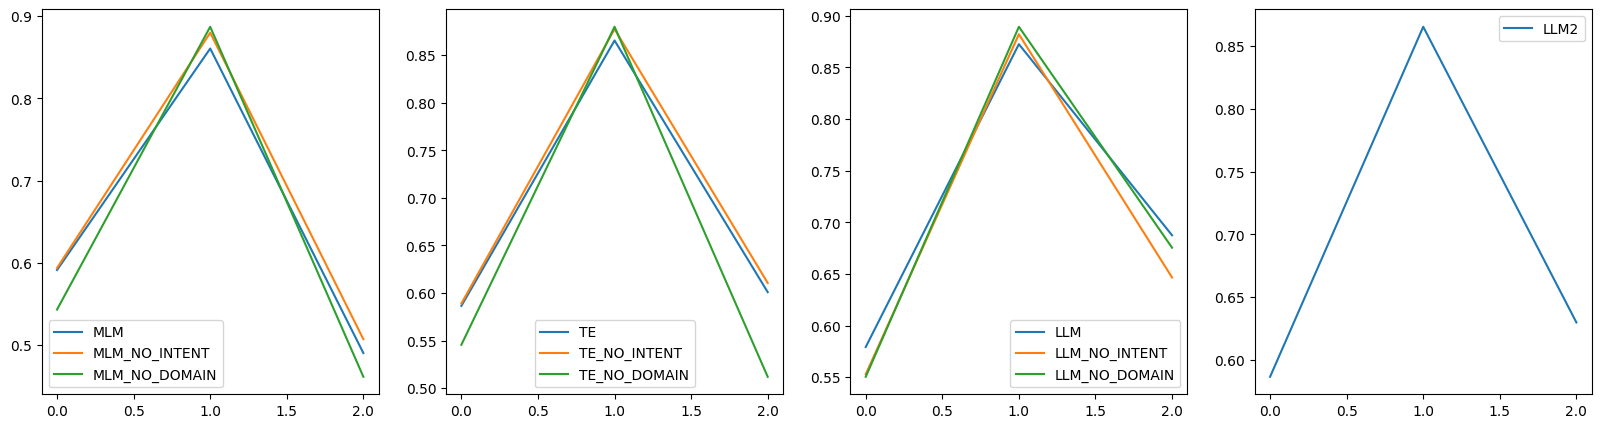

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, row in eval_df.iterrows():
    axes[int(i) // 3].plot(
        range(3),
        [row["ambiguous_accuracy"], row["unambiguous_accuracy"], row["disambiguated_accuracy"]],
        label=row["method"],
    )
    axes[int(i) // 3].legend()
plt.show()

In [42]:
df.to_csv(f"./data/{dataset_name}_ambiguous_top{top_n}+DOMAIN+LLM+Intent+MLM+TE+LLM+eval.csv", index=False)

In [4]:
df = pd.read_csv(f"./data/{dataset_name}_ambiguous_top{top_n}+DOMAIN+LLM+Intent+MLM+TE+LLM+eval.csv")

### Intent+Domain Experiments

In [14]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["raw"]))
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["analyzed"]))
chain_ = RunnableParallel(raw=lm1, analyzed=lm2)

In [15]:
methods = ["RAW_NO_DOMAIN", "RAW_NO_INTENT", "RAW_ALL"]

In [16]:
for method in methods:
    for df_index in tqdm(range(len(df))):
        evaluation = {"raw": [], "analyzed": []}
        question: str = df.loc[df_index, "question"]
        answer: str = df.loc[df_index, "answer"] if "answer" in df else ""

        response: dict[str, AnswerStr] = chain_.invoke(
            {
                "analyzed": {
                    "query": question,
                    "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "",
                    "domain": (
                        categories[df.loc[df_index, "domain_idx"]]
                        if df.loc[df_index, "domain_idx"] < len(categories)
                        else None
                    )
                    if "NO_DOMAIN" not in method
                    else "",
                },
                "raw": {
                    "query": question,
                    "intent": "",
                    "domain": "",
                },
            },
            RunnableConfig(configurable={"llm": "gpt35"}),
        )

        response_: AnswerJudge = chain_score2.invoke(
            {
                "answer": answer if answer else response["raw"].answer,
                "raw": response["raw"].answer,
                "analyzed": response["analyzed"].answer,
                "query": question,
            }
        )

        df.loc[df_index, f"{method}_raw_question_answered_by_gpt35_correct"] = response_.bit1 == 1
        df.loc[df_index, f"{method}_analyzed_question_answered_by_gpt35_correct"] = response_.bit2 == 1

        df.loc[df_index, f"{method}_analyzed_question_answered_by_gpt35"] = response["analyzed"].answer
        df.loc[df_index, f"{method}_raw_question_answered_by_gpt35"] = response["raw"].answer

100%|██████████| 150/150 [07:07<00:00,  2.85s/it]


In [18]:
df = df.rename(
    columns={
        col: col.replace("raw", "analyzed")
        if "raw" in col
        else (col.replace("analyzed", "raw") if "analyzed" in col else col)
        for col in df.columns
    }
)

In [19]:
eval_df = pd.DataFrame(columns=["method", "raw_accuracy", "analyzed_accuracy"])

for method in methods:
    eval_df = pd.concat(
        [
            eval_df,
            pd.DataFrame(
                [
                    {
                        "method": method,
                        "raw_accuracy": df[f"{method}_raw_question_answered_by_gpt35_correct"].mean(),
                        "analyzed_accuracy": df[f"{method}_analyzed_question_answered_by_gpt35_correct"].mean(),
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
eval_df

/tmp/ipykernel_5505/2371604126.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,method,raw_accuracy,analyzed_accuracy
0,RAW_NO_DOMAIN,0.853333,0.866667
1,RAW_NO_INTENT,0.846667,0.860000
2,RAW_ALL,0.880000,0.886667


In [20]:
df.to_csv(f"./data/{dataset_name}_{experiment}+eval.csv", index=False)